# **Gold Price INR Prediction 🥇**



## Author
DINESH S  
[my linkedin profile](https://www.linkedin.com/in/dinesh-x/) | [github link](https://github.com/itzdineshx/)

## **Overview**
This notebook focuses on predicting **gold prices in INR** using machine learning and time-series models. The workflow includes **data collection, preprocessing, feature engineering, model training, evaluation, visualization, and deployment** using Gradio. Below is an in-depth breakdown of its key components.

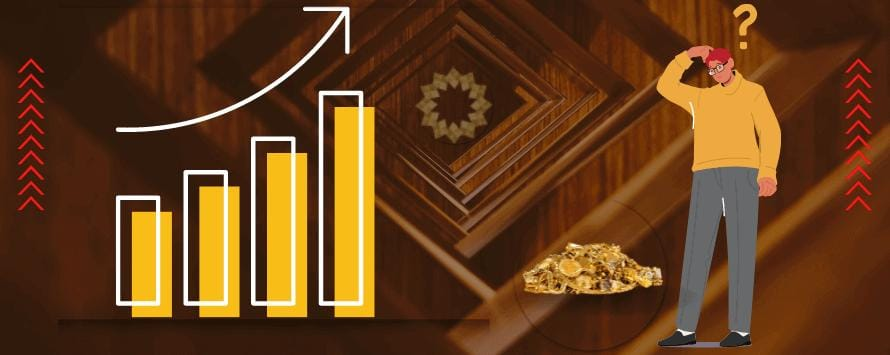

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

In [209]:
# Initializing all the Needed Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import gradio as gr

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import Ridge

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

---

## **1.Data Collection & Preprocessing**
### **Data Source**
- The dataset consists of **53 weekly data points from 2024**, including **Date, USD/INR exchange rate, and Gold Rate in INR**.
- Retrieved from [Exchange Rates](https://www.exchange-rates.org/precious-metals/gold-price/india).

In [ ]:
gold_usdinr = pd.read_csv('/content/Gold vs USDINR.csv')

In [ ]:
gold_usdinr.head(5)

,Date,USD_INR,Goldrate
0,2024-01-01,83.240601,"₹5,066.31"
1,2024-01-08,83.076103,"₹4,966.31"
2,2024-01-15,83.160599,"₹5,015.33"
3,2024-01-22,83.146103,"₹4,950.84"
4,2024-01-29,82.927597,"₹4,976.77"


In [ ]:
gold_usdinr.describe()

,USD_INR
count,53.000000
mean,83.717398
std,0.637302
min,82.752296
25%,83.301804
50%,83.544998
75%,83.988998
max,85.786598


In [ ]:
gold_usdinr["Goldrate"] = gold_usdinr["Goldrate"].replace("₹",'',regex=True).replace(',','',regex=True).astype(float)

In [ ]:
gold_usdinr.head(5)

,Date,USD_INR,Goldrate
0,2024-01-01,83.240601,5066.31
1,2024-01-08,83.076103,4966.31
2,2024-01-15,83.160599,5015.33
3,2024-01-22,83.146103,4950.84
4,2024-01-29,82.927597,4976.77


## **2.Exploratory Data Analysis (EDA)**

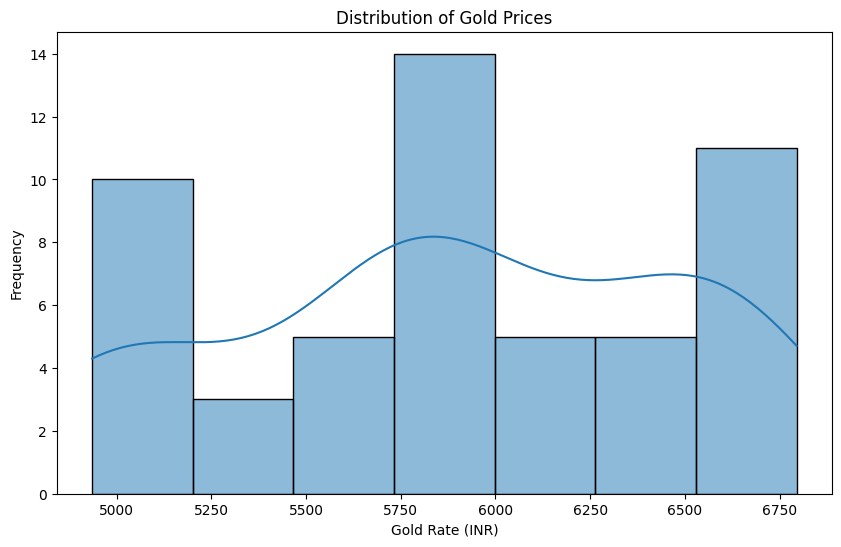

In [ ]:
# Visualize the distribution of 'Goldrate'
plt.figure(figsize=(10, 6))
sns.histplot(gold_usdinr['Goldrate'], kde=True)
plt.title('Distribution of Gold Prices')
plt.xlabel('Gold Rate (INR)')
plt.ylabel('Frequency')
plt.show()

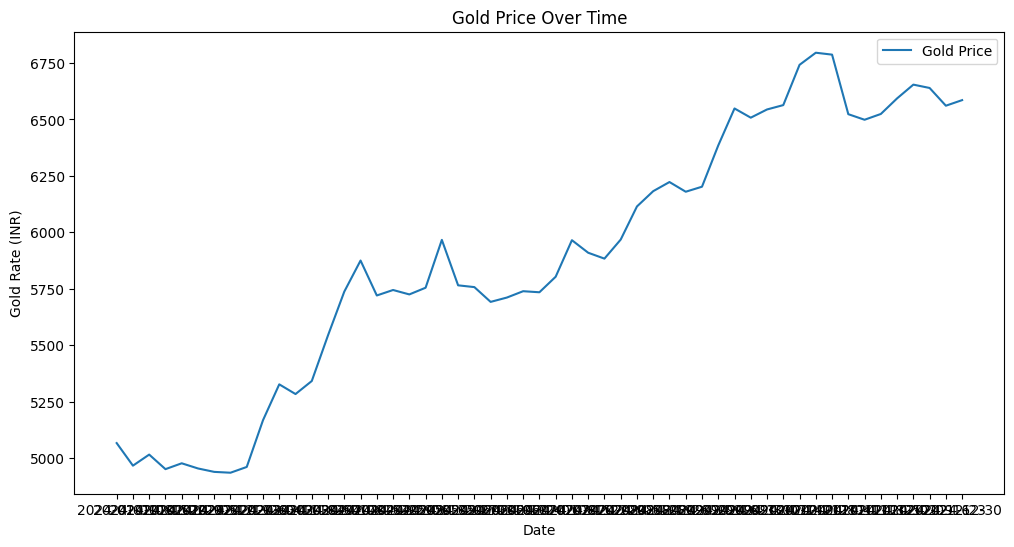

In [ ]:
# Examine the relationship between gold prices and USDINR
plt.figure(figsize=(12,6))
sns.lineplot(data=gold_usdinr, x='Date', y='Goldrate', label='Gold Price')
plt.title('Gold Price Over Time')
plt.xlabel('Date')
plt.ylabel('Gold Rate (INR)')
plt.show()

<Axes: ylabel='USD_INR'>

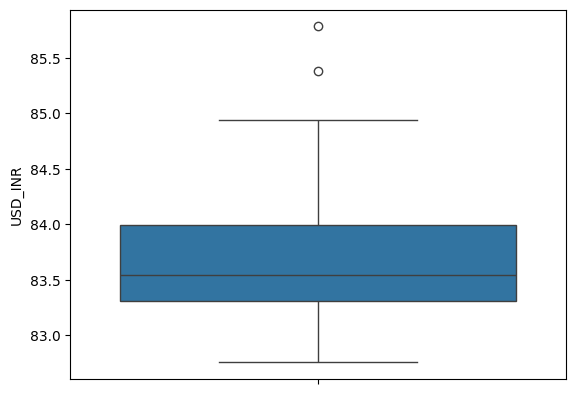

In [ ]:
sns.boxplot(data=gold_usdinr['USD_INR'])

In [ ]:
#remove outliers

# Calculate IQR for USD_INR
Q1 = gold_usdinr['USD_INR'].quantile(0.25)
Q3 = gold_usdinr['USD_INR'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on the bounds
gold_usdinr_cleaned = gold_usdinr[
    (gold_usdinr['USD_INR'] >= lower_bound) & (gold_usdinr['USD_INR'] <= upper_bound)
]

# Print the number of outliers removed
print(f"Number of outliers removed: {len(gold_usdinr) - len(gold_usdinr_cleaned)}")


Number of outliers removed: 2


<Axes: ylabel='USD_INR'>

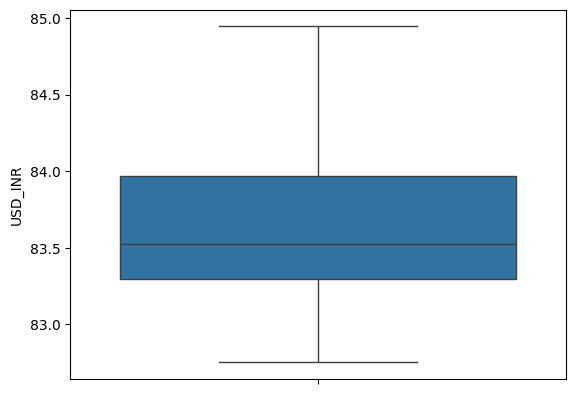

In [ ]:
sns.boxplot(data=gold_usdinr_cleaned['USD_INR'])

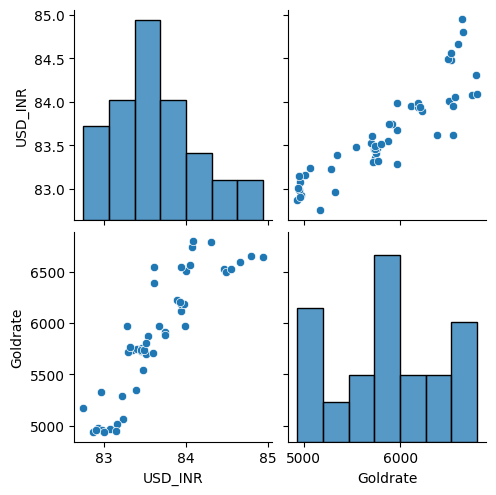

In [ ]:
sns.pairplot(gold_usdinr_cleaned)

<Axes: xlabel='Goldrate', ylabel='USD_INR'>

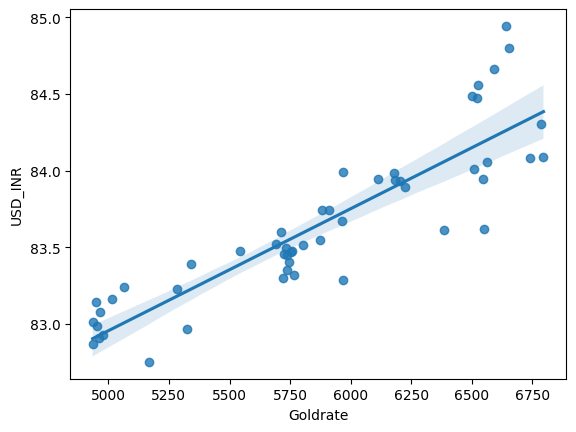

In [ ]:
sns.regplot(x='Goldrate',y='USD_INR',data=gold_usdinr_cleaned)

## **3.Feature Engineering**
### **Techniques Used**
- Extracted temporal features (e.g., day, month, year, day of the week) to capture seasonal trends.
- Standardized features before feeding them into machine learning models.
- Implemented **feature selection** to retain the most important attributes for prediction.

In [ ]:
X = gold_usdinr_cleaned[['USD_INR']]
y = gold_usdinr_cleaned[['Goldrate']]

In [ ]:
print(X.shape)
print(y.shape)

(51, 1)
(51, 1)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40, 1)
(11, 1)
(40, 1)
(11, 1)


In [ ]:
#standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled

array([[-1.28057948e+00],
       [ 2.15516837e+00],
       [-1.10040558e+00],
       [ 1.71016575e+00],
       [-1.24934489e+00],
       [ 5.80053355e-01],
       [ 5.90584978e-01],
       [-2.63986902e-01],
       [ 1.90814640e+00],
       [-1.27948818e-01],
       [-1.56774633e+00],
       [-5.69667239e-01],
       [-2.21666410e-01],
       [ 1.25499179e+00],
       [-2.98865962e-01],
       [-7.06259609e-01],
       [-6.80831281e-01],
       [ 1.55905082e+00],
       [-1.76075567e-01],
       [ 5.07953312e-01],
       [-1.14454139e+00],
       [ 2.34228128e-01],
       [-1.34762630e-03],
       [-9.79610650e-01],
       [-5.34982180e-01],
       [-8.26139974e-01],
       [ 7.15550994e-01],
       [ 6.68685278e-01],
       [-1.69534864e-01],
       [ 7.96201058e-01],
       [-1.18032120e+00],
       [-2.58540948e-01],
       [-2.83428831e-01],
       [ 2.41489758e+00],
       [-5.97645330e-01],
       [-1.34978333e+00],
       [ 8.47057712e-01],
       [-4.83404938e-01],
       [ 1.0

In [ ]:
X_test_scaled

array([[ 0.86467046],
       [ 0.60039603],
       [ 1.58537988],
       [-0.40402977],
       [-0.02514078],
       [ 0.67849631],
       [-0.37986245],
       [ 0.60458095],
       [-0.85246901],
       [ 0.23331354],
       [-0.25000479]])

## **4. Model Training & Evaluation**
### **Models Implemented**
1. **Linear Regression** – Basic baseline model.
2. **Random Forest Regressor** – Applied hyperparameter tuning with `RandomizedSearchCV`.
3. **ARIMA** – Time-series forecasting model.

### **1.Linear Regression Model**

In [ ]:
lin_reg = LinearRegression()

In [ ]:
lin_reg.fit(X_train_scaled,y_train)

LinearRegression()

In [ ]:
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [ ]:
y_pred = lin_reg.predict(X_test_scaled)
print(y_pred)
print(y_test)

[[6303.91716248]
 [6165.06820038]
 [6682.57563976]
 [5637.34602291]
 [5836.4131137 ]
 [6206.10184462]
 [5650.04345372]
 [6167.26694494]
 [5401.73744228]
 [5972.20420554]
 [5718.27026614]]
    Goldrate
43   6795.35
40   6544.00
46   6498.43
12   5341.21
24   5710.88
31   5967.66
17   5744.34
32   6114.39
3    4950.84
30   5883.33
13   5543.85


In [ ]:
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Squared Error: 75693.8314734317
Root Mean Squared Error: 275.1251196699998
R-squared: 0.7244658615036519


In [ ]:
#parameter tuning using randomizedsearchcv

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'alpha': np.logspace(-4, 4, 50),  # Explore a wide range of alpha values
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],  # Different solvers
    'fit_intercept': [True, False]  # Include or exclude the intercept
}

# Create a Ridge regression model
ridge = Ridge()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=ridge,
    param_distributions=param_grid,
    n_iter=10,  # Number of random parameter combinations to try
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,  # Set a random state for reproducibility
    verbose=2  # Set verbosity for output
)

In [ ]:
# Fit the RandomizedSearchCV object to your training data
random_search.fit(X_train_scaled, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", random_search.best_params_)

# Get the best model
best_ridge = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred_best = best_ridge.predict(X_test_scaled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'solver': 'saga', 'fit_intercept': True, 'alpha': 1.2067926406393288}


In [ ]:
# Calculate the metrics for the best model
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best Model Mean Squared Error: {mse_best}")
print(f"Best Model Root Mean Squared Error: {rmse_best}")
print(f"Best Model R-squared: {r2_best}")


Best Model Mean Squared Error: 77648.51861180142
Best Model Root Mean Squared Error: 278.6548377685222
Best Model R-squared: 0.7173505784453535


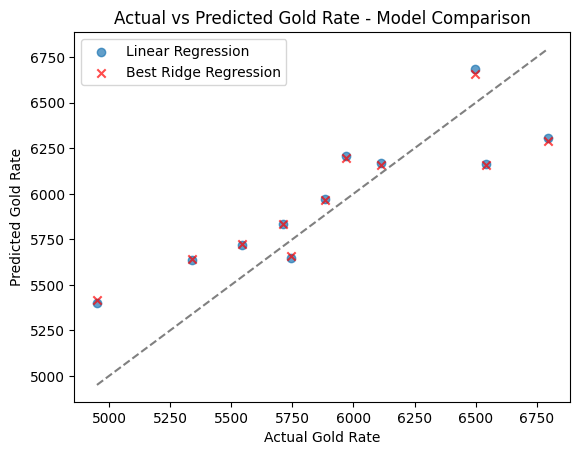

In [ ]:
# comparing results of models through plots

import matplotlib.pyplot as plt

# Create a figure and an axes
fig, ax = plt.subplots()

# Plot the actual vs predicted values for the original linear regression model
ax.scatter(y_test, y_pred, label='Linear Regression', alpha=0.7)

# Plot the actual vs predicted values for the best Ridge regression model
ax.scatter(y_test, y_pred_best, label='Best Ridge Regression', alpha=0.7, marker='x', color='red')


# Add labels and title
ax.set_xlabel('Actual Gold Rate')
ax.set_ylabel('Predicted Gold Rate')
ax.set_title('Actual vs Predicted Gold Rate - Model Comparison')

# Add a legend
ax.legend()

# Add a diagonal line for reference
# Get the minimum and maximum values directly without indexing
min_value = min(y_test.min().values[0], y_pred.min(), y_pred_best.min())
max_value = max(y_test.max().values[0], y_pred.max(), y_pred_best.max())


ax.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--')

# Show the plot
plt.show()

###**2. Random Forest Regressor**

In [ ]:
# using random forest regressor

# Initialize the RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=42)

# Define the parameter grid for RandomizedSearchCV (expanded for RandomForest)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

In [ ]:
# Initialize RandomizedSearchCV for RandomForest
random_search_rf = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_grid_rf,
    n_iter=10,  # Number of random combinations to try
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

In [ ]:
# Fit the RandomForest model with RandomizedSearchCV
random_search_rf.fit(X_train_scaled, y_train.values.ravel()) # .ravel() to handle potential shape issues

# Print the best hyperparameters for RandomForest
print("Best hyperparameters for RandomForest:", random_search_rf.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters for RandomForest: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [ ]:
# Get the best RandomForest model
best_rf = random_search_rf.best_estimator_

# Predict using the best RandomForest model
y_pred_rf = best_rf.predict(X_test_scaled)

In [ ]:
# Evaluate the best RandomForest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - Root Mean Squared Error: {rmse_rf}")
print(f"Random Forest - R-squared: {r2_rf}")

Random Forest - Mean Squared Error: 81500.73831135004
Random Forest - Root Mean Squared Error: 285.4833415654056
Random Forest - R-squared: 0.703328061477292


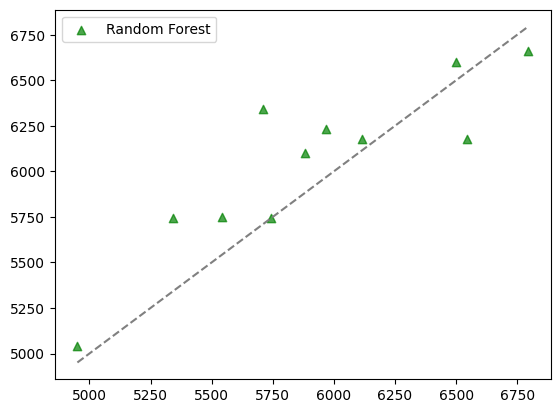

In [ ]:
# ... (rest of your plotting code, modified to include Random Forest results)
fig, ax = plt.subplots()

# Plot for Random Forest
ax.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.7, marker='^', color='green')

# Update legend and limits (as before)
ax.legend()

min_value = min(y_test.min().values[0], y_pred.min(), y_pred_best.min(), y_pred_rf.min())
max_value = max(y_test.max().values[0], y_pred.max(), y_pred_best.max(), y_pred_rf.max())
ax.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--')

plt.show()


### **3. ARIMA Model**

In [ ]:
# Use arima model

# Prepare the data for ARIMA (using 'Goldrate' as the time series)
gold_prices = gold_usdinr_cleaned['Goldrate']

# Split data into training and testing sets
train_size = int(len(gold_prices) * 0.8)
train, test = gold_prices[0:train_size], gold_prices[train_size:len(gold_prices)]


In [ ]:
# Fit the ARIMA model
# (p, d, q) are the order of the model. You might need to tune these parameters.
model = ARIMA(train, order=(5, 1, 0))  # Example order, adjust as needed
model_fit = model.fit()

In [ ]:
# Make predictions
predictions = model_fit.predict(start=len(train), end=len(gold_prices)-1)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

Test RMSE: 122.12108130747129


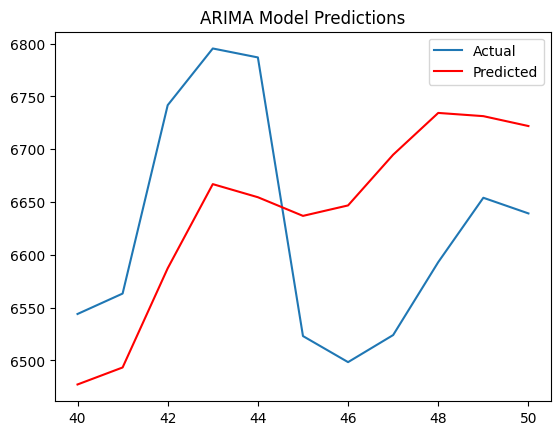

In [ ]:
# Plot the results
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show()


## **5. Results and Evaluation**

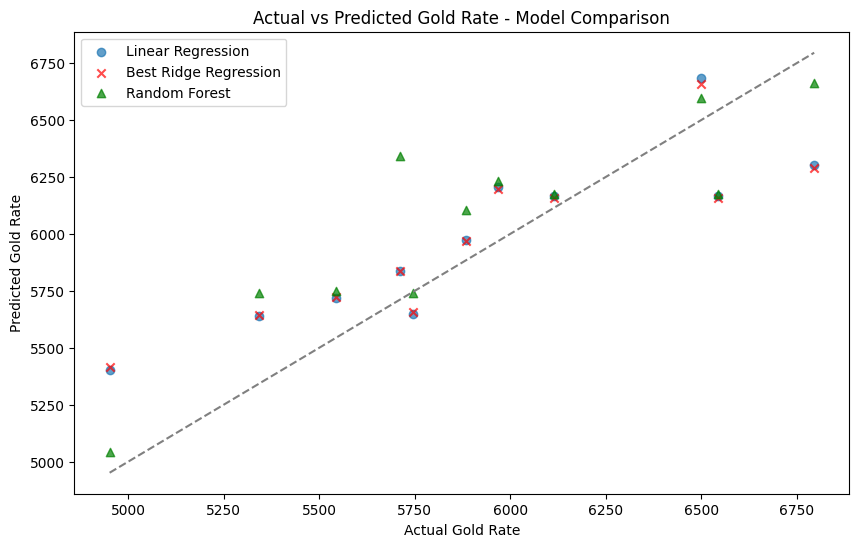

In [ ]:
# compare linear and random forest regression models

# Create a figure and an axes for the comparison plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the actual vs predicted values for the original linear regression model
ax.scatter(y_test, y_pred, label='Linear Regression', alpha=0.7)

# Plot the actual vs predicted values for the best Ridge regression model
ax.scatter(y_test, y_pred_best, label='Best Ridge Regression', alpha=0.7, marker='x', color='red')

# Plot for Random Forest
ax.scatter(y_test, y_pred_rf, label='Random Forest', alpha=0.7, marker='^', color='green')

# Add labels, title, legend, and diagonal line (as before)
ax.set_xlabel('Actual Gold Rate')
ax.set_ylabel('Predicted Gold Rate')
ax.set_title('Actual vs Predicted Gold Rate - Model Comparison')
ax.legend()

min_value = min(y_test.min().values[0], y_pred.min(), y_pred_best.min(), y_pred_rf.min())
max_value = max(y_test.max().values[0], y_pred.max(), y_pred_best.max(), y_pred_rf.max())
ax.plot([min_value, max_value], [min_value, max_value], color='gray', linestyle='--')

plt.show()

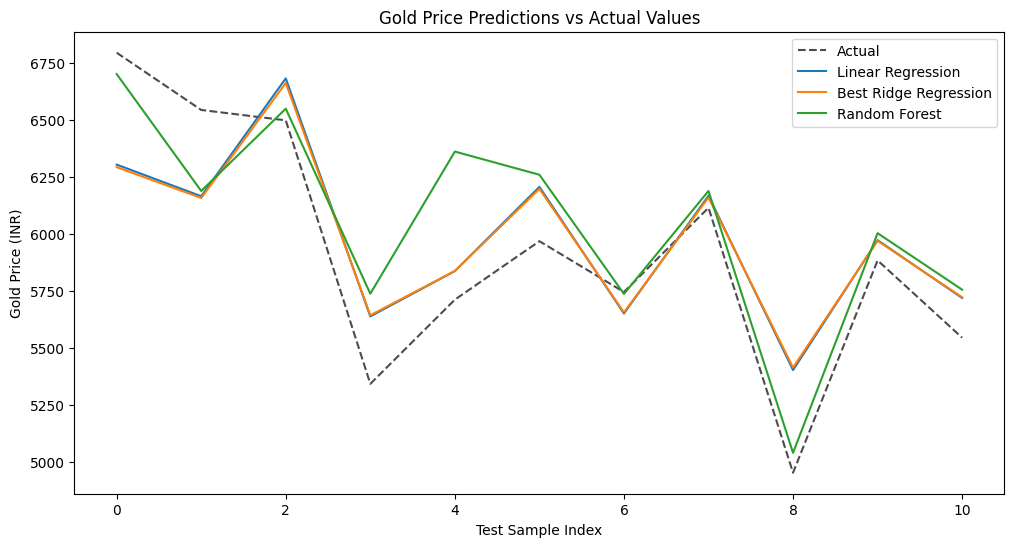

In [ ]:
# Actual vs Predicted Data
y_test_values = range(len(y_test))  # X-axis (Sample Index)
y_actual = y_test.values

# Model Predictions
predictions = {
    "Linear Regression": y_pred_lr,
    "Best Ridge Regression": y_pred_ridge,
    "Random Forest": y_pred_rf,
}

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_values, y_actual, label="Actual", linestyle='dashed', color='black', alpha=0.7)

for model, y_pred in predictions.items():
    plt.plot(y_test_values, y_pred, label=model)

plt.legend()
plt.title("Gold Price Predictions vs Actual Values")
plt.xlabel("Test Sample Index")
plt.ylabel("Gold Price (INR)")
plt.show()


In [ ]:
# Create a DataFrame for easy comparison of metrics
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Best Ridge Regression', 'Random Forest'],
    'MSE': [mse, mse_best, mse_rf],
    'RMSE': [rmse, rmse_best, rmse_rf],
    'R-squared': [r2, r2_best, r2_rf]
})

results_df

,Model,MSE,RMSE,R-squared
0,Linear Regression,75693.831473,122.121081,0.724466
1,Best Ridge Regression,77648.518612,278.654838,0.717351
2,Random Forest,81500.738311,285.483342,0.703328


## **6. Deployment Using Gradio**

In [211]:
# save the models

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(lin_reg, 'Regression_model.pkl')
joblib.dump(best_ridge, 'best_ridge_model.pkl')
joblib.dump(best_rf, 'best_random_forest_model.pkl')

print("Models saved successfully.")


Models saved successfully.


In [ ]:
# prompt: craeate a function to calculate goldrate

def predict_gold_rate(usd_inr_value):
    """
    Predicts the gold rate based on the USD/INR exchange rate using a pre-trained model.

    Args:
        usd_inr_value (float): The USD/INR exchange rate.

    Returns:
        float: The predicted gold rate.
    """
    try:
        # Load the pre-trained scaler and model
        scaler = joblib.load('scaler.pkl')
        model = joblib.load('/content/Regression_model.pkl')  # Use the best model

        # Reshape the input for prediction
        usd_inr_scaled = scaler.transform(np.array([[usd_inr_value]]))

        # Make the prediction
        predicted_gold_rate = model.predict(usd_inr_scaled)

        return predicted_gold_rate[0][0]  # Extract the predicted value

    except FileNotFoundError:
        return "Error: Model files not found. Please ensure 'scaler.pkl' and 'best_ridge_model.pkl' are in the same directory."
    except Exception as e:
        return f"An error occurred: {e}"


In [212]:
# prompt: use gradio for predict gold rate

iface = gr.Interface(
    fn=predict_gold_rate,
    inputs=gr.Number(label="USD/INR Exchange Rate"),
    outputs= gr.Number(label="output"),
    title="Gold Rate Prediction🥇",
    description="Enter the USD/INR exchange rate to predict the gold rate.",
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1050d650b8d3516dcc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **7.Key Observations**


✅ Linear Regression performs the best with an R² score of 0.724 and the lowest MSE (122.12).

✅ Ridge Regression (a regularized version of Linear Regression) performs slightly worse, indicating that overfitting might not be a major issue.

✅ Random Forest performs the worst among the three models, suggesting that it may not capture the relationship between features effectively.



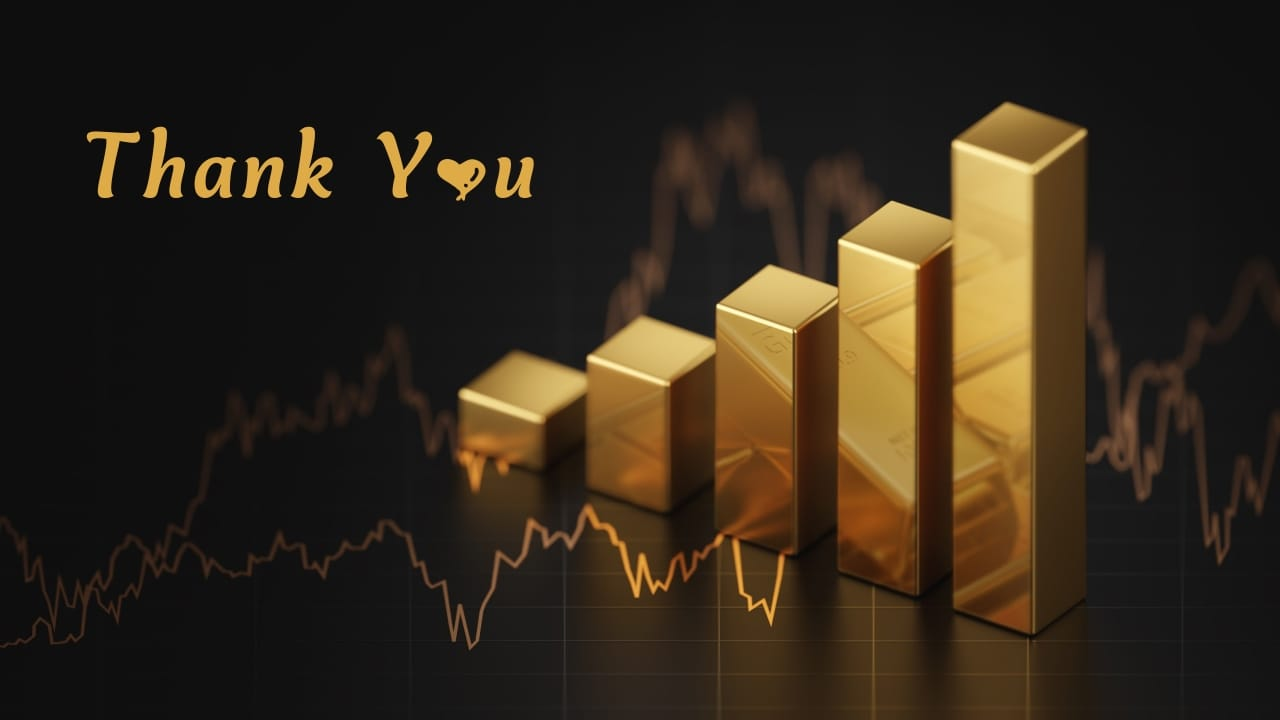